# Adaptive RAG Cohere Command R

Adaptive RAG is a strategy for RAG that unites (1) [query analysis](https://blog.langchain.dev/query-construction/) with (2) [active / self-corrective RAG](https://blog.langchain.dev/agentic-rag-with-langgraph/).

In the paper, they report query analysis to route across:

* No Retrieval (LLM answers)
* Single-shot RAG
* Iterative RAG

Let's build on this to perform query analysis to route across some more interesting cases:

* No Retrieval (LLM answers)
* Web-search
* Iterative RAG

We'll use [Command R](https://cohere.com/blog/command-r), a recent release from Cohere that:

* Has strong accuracy on RAG and Tool Use
* Has 128k context
* Has low latency 
  
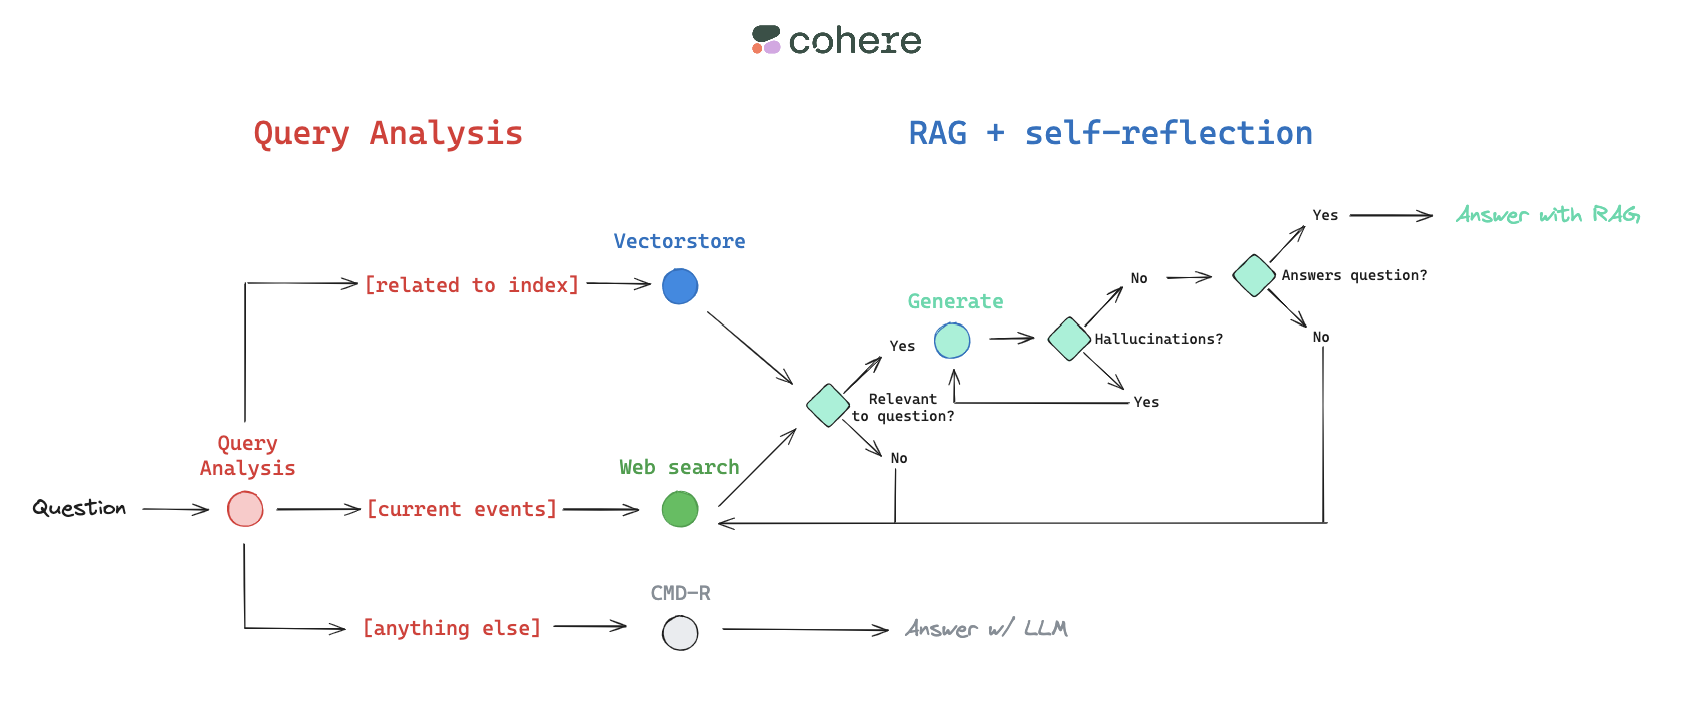

# Environment

In [ ]:
! pip install --quiet langchain langchain_cohere langchain-openai tiktoken langchainhub chromadb langgraph

In [ ]:
### LLMs
import os

os.environ["COHERE_API_KEY"] = "<your-api-key>"

In [ ]:
# ### Tracing (optional)
# os.environ['LANGCHAIN_TRACING_V2'] = 'true'
# os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
# os.environ['LANGCHAIN_API_KEY'] ='<your-api-key>'

## Index

In [1]:
### Build Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_cohere import CohereEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma

# Set embeddings
embd = CohereEmbeddings()

# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=512, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorstore
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    embedding=embd,
)

retriever = vectorstore.as_retriever()

## LLMs

We use a router to pick between tools. 
 
Cohere model decides which tool(s) to call, as well as the how to query them.

In [2]:
### Router

from langchain_cohere import ChatCohere
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field


# Data model
class web_search(BaseModel):
    """
    The internet. Use web_search for questions that are related to anything else than agents, prompt engineering, and adversarial attacks.
    """

    query: str = Field(description="The query to use when searching the internet.")


class vectorstore(BaseModel):
    """
    A vectorstore containing documents related to agents, prompt engineering, and adversarial attacks. Use the vectorstore for questions on these topics.
    """

    query: str = Field(description="The query to use when searching the vectorstore.")


# Preamble
preamble = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""

# LLM with tool use and preamble
llm = ChatCohere(model="command-r", temperature=0)
structured_llm_router = llm.bind_tools(
    tools=[web_search, vectorstore], preamble=preamble
)

# Prompt
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
response = question_router.invoke(
    {"question": "Who will the Bears draft first in the NFL draft?"}
)
print(response.response_metadata["tool_calls"])
response = question_router.invoke({"question": "What are the types of agent memory?"})
print(response.response_metadata["tool_calls"])
response = question_router.invoke({"question": "Hi how are you?"})
print("tool_calls" in response.response_metadata)

[{'id': 'f811e3b9-052e-49db-a234-5fc3efbcc5ba', 'function': {'name': 'web_search', 'arguments': '{"query": "NFL draft bears first pick"}'}, 'type': 'function'}]
[{'id': '4bc53113-8f32-4d6d-ac9b-c07ef9aae9fd', 'function': {'name': 'vectorstore', 'arguments': '{"query": "types of agent memory"}'}, 'type': 'function'}]
False


In [4]:
### Retrieval Grader


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# Prompt
preamble = """You are a grader assessing relevance of a retrieved document to a user question. \n
If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# LLM with function call
llm = ChatCohere(model="command-r", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments, preamble=preamble)

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "types of agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
response = retrieval_grader.invoke({"question": question, "document": doc_txt})
print(response)

binary_score='yes'


Generate

In [5]:
### Generate

from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser

# Preamble
preamble = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise."""

# LLM
llm = ChatCohere(model_name="command-r", temperature=0).bind(preamble=preamble)


# Prompt
def prompt(x):
    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(
                f"Question: {x['question']} \nAnswer: ",
                additional_kwargs={"documents": x["documents"]},
            )
        ]
    )


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"documents": docs, "question": question})
print(generation)

There are three types of agent memory: sensory memory, short-term memory, and long-term memory.


In [6]:
### LLM fallback

from langchain_core.output_parsers import StrOutputParser

# Preamble
preamble = """You are an assistant for question-answering tasks. Answer the question based upon your knowledge. Use three sentences maximum and keep the answer concise."""

# LLM
llm = ChatCohere(model_name="command-r", temperature=0).bind(preamble=preamble)


# Prompt
def prompt(x):
    return ChatPromptTemplate.from_messages(
        [HumanMessage(f"Question: {x['question']} \nAnswer: ")]
    )


# Chain
llm_chain = prompt | llm | StrOutputParser()

# Run
question = "Hi how are you?"
generation = llm_chain.invoke({"question": question})
print(generation)

I don't have feelings as an AI chatbot, but I'm here to assist you with any queries or concerns you may have. How can I help you today?


In [7]:
### Hallucination Grader


# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# Preamble
preamble = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

# LLM with function call
llm = ChatCohere(model="command-r", temperature=0)
structured_llm_grader = llm.with_structured_output(
    GradeHallucinations, preamble=preamble
)

# Prompt
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        # ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

In [8]:
### Answer Grader


# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# Preamble
preamble = """You are a grader assessing whether an answer addresses / resolves a question \n
Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""

# LLM with function call
llm = ChatCohere(model="command-r", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer, preamble=preamble)

# Prompt
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

## Web Search Tool

In [9]:
### Search
# os.environ['TAVILY_API_KEY'] ='<your-api-key>'

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults()

# Graph

Capture the flow in as a graph.

## Graph state

In [10]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """|
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

## Graph Flow

In [11]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def llm_fallback(state):
    """
    Generate answer using the LLM w/o vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---LLM Fallback---")
    question = state["question"]
    generation = llm_chain.invoke({"question": question})
    return {"question": question, "generation": generation}


def generate(state):
    """
    Generate answer using the vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    if not isinstance(documents, list):
        documents = [documents]

    # RAG generation
    generation = rag_chain.invoke({"documents": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}


### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})

    # Fallback to LLM or raise error if no decision
    if "tool_calls" not in source.additional_kwargs:
        print("---ROUTE QUESTION TO LLM---")
        return "llm_fallback"
    if len(source.additional_kwargs["tool_calls"]) == 0:
        raise "Router could not decide source"

    # Choose datasource
    datasource = source.additional_kwargs["tool_calls"][0]["function"]["name"]
    if datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
    else:
        print("---ROUTE QUESTION TO LLM---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, WEB SEARCH---")
        return "web_search"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

## Build Graph

In [12]:
import pprint

from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # rag
workflow.add_node("llm_fallback", llm_fallback)  # llm

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
        "llm_fallback": "llm_fallback",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "web_search": "web_search",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",  # Hallucinations: re-generate
        "not useful": "web_search",  # Fails to answer question: fall-back to web-search
        "useful": END,
    },
)
workflow.add_edge("llm_fallback", END)

# Compile
app = workflow.compile()

In [13]:
# Run
inputs = {
    "question": "What player are the Bears expected to draft first in the 2024 NFL draft?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint.pprint(f"Node '{key}':")
        # Optional: print full state at each node
    pprint.pprint("\n---\n")

# Final generation
pprint.pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
'The Bears are expected to draft Caleb Williams with their first pick.'


Trace:

https://smith.langchain.com/public/623da7bb-84a7-4e53-a63e-7ccd77fb9be5/r

In [14]:
# Run
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint.pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

# Final generation
pprint.pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
'Sensory, short-term, and long-term memory.'


Trace:

https://smith.langchain.com/public/57f3973b-6879-4fbe-ae31-9ae524c3a697/r

In [15]:
# Run
inputs = {"question": "Hello, how are you today?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint.pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

# Final generation
pprint.pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO LLM---
---LLM Fallback---
"Node 'llm_fallback':"
'\n---\n'
("I don't have feelings as an AI assistant, but I'm here to help you with your "
 'queries. How can I assist you today?')


Trace: 

https://smith.langchain.com/public/1f628ee4-8d2d-451e-aeb1-5d5e0ede2b4f/r